## PCA

In [ ]:
import os
import torch

from scanner_domain_shift.utilities_and_helpers.slide.customDataLoader import generate_testloader_only
from scanner_domain_shift.utilities_and_helpers.slide.custom_slide_container import SlideContainer

scan = ["cs2", "nz20", "nz210", "p1000", "gt450"]

def get_testloaders():
    reverse_dict = { 2: "excluded", 1 : "tumor", 0: "normal"}
    annotation_file = 'data/scc.json'

    test_files_dict = {}

    for scanner in scan:    
        dataprep_folder = 'data/dataprep'

        # Load serialized data
        
        test_data = torch.load(os.path.join(dataprep_folder, f'{scanner}_test.pt'))

        # Reconstruct SlideContainer objects
        test_files_dict[scanner] = [SlideContainer.from_dict(data, annotation_file) for data in test_data]

    batch_size = 64


    print("generating dataloaders...")
    test_loaders = {}

    for scanner in scan:
        test_loaders[scanner] = generate_testloader_only(test_files_dict[scanner], batch_size, reverse_dict)
        print(f"Generated testloader for {scanner}")
    

    return test_loaders

testloaders = get_testloaders()



/tmp/ipykernel_833254/2594510170.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(dataprep_folder, f'{scanner}_test.pt'))


generating dataloaders...
Generated testloader for cs2
Generated testloader for nz20
Generated testloader for nz210
Generated testloader for p1000
Generated testloader for gt450


In [ ]:
from scanner_domain_shift.utilities_and_helpers.helper_methods import inst_model
from scanner_domain_shift.classifier_training.model_train_test import parseName
import torch

#use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelpath = "sc_domain_shift/models/cs2_TwoLayerNN_epoch_12_lr_0.0001_512.pth" 
#parse model name
scannername, lr, epochs, modelname, hidden_size, hidden_size1, hidden_size2 = parseName(modelpath)
if modelname != "TwoLayerNN":
    print("Model not supported")
    exit(1)
input_size = 224*224*3
model, flatten_patches = inst_model(modelname, input_size, hidden_size, hidden_size1, hidden_size2, device)
model.to(device)
print(model)


model.to(device)
reduced_representations = {}
for scanner in scan:
    reduced_representations[scanner] = []  # Initialize as a list
    temp_batches = []  # Temporary list to store batches
    for patches, _, _ in testloaders[scanner]:
        patches = patches.to(device)
        patches = patches.view(patches.size(0), -1) if flatten_patches else patches
        
        with torch.no_grad():
            reduced_rep = model.get_reduced_representation(patches)
            temp_batches.append(reduced_rep.cpu())  # Store tensors directly
        # print(f"Reduced representation shape for {scanner}: {reduced_rep.shape}")
    
    # Concatenate all batches for the scanner
    reduced_representations[scanner] = torch.cat(temp_batches, dim=0)
    print(f"Final reduced representation shape for {scanner}: {reduced_representations[scanner].shape}")

print(f"reduced_representations.keys(): {reduced_representations.keys()}")



/home/khinke/miniconda3/envs/cudacopy2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scannername: cs2
modelname: TwoLayerNN
Parsed epochs: 12, learning rate: 0.0001, modelname: TwoLayerNN, hidden sizes: 512, None, None
TwoLayerNN(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
#PCA image savepath
scannername = "cs2"
pca_savepath = f"figures/PCA/{scannername}/"
if not os.path.exists(pca_savepath):
    os.makedirs(pca_savepath)

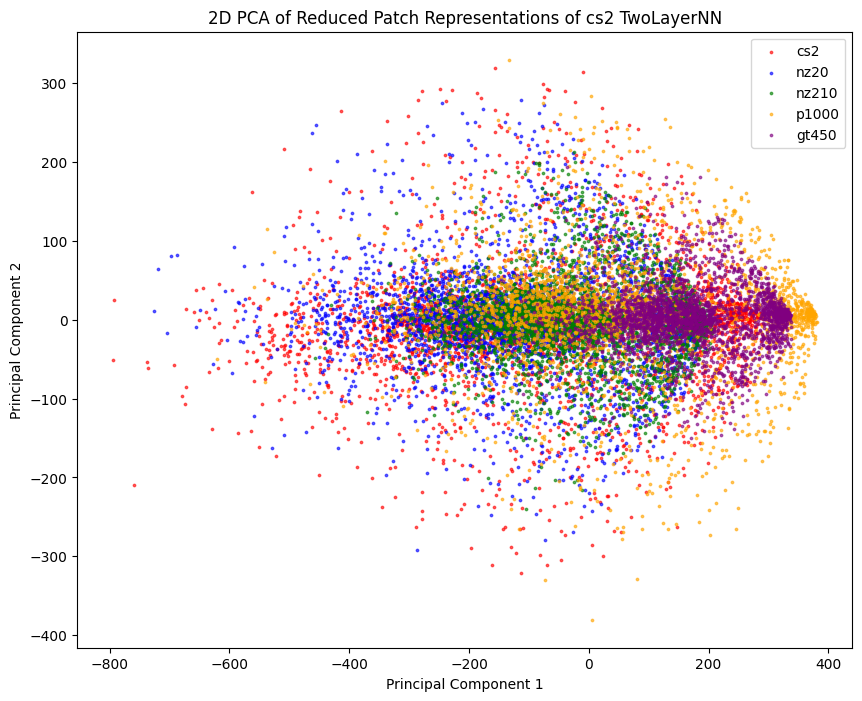

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Combine all reduced representations into one tensor and create labels
all_representations = []
labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = {}

for i, scanner in enumerate(scan):
    all_representations.append(reduced_representations[scanner])
    labels.extend([scanner] * reduced_representations[scanner].shape[0])
    color_map[scanner] = colors[i]

all_representations = torch.cat(all_representations, dim=0)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_2d = pca.fit_transform(all_representations.numpy())

# Plot the 2D PCA
plt.figure(figsize=(10, 8))
for scanner in scan:
    indices = [i for i, label in enumerate(labels) if label == scanner]
    plt.scatter(reduced_2d[indices, 0], reduced_2d[indices, 1], label=scanner, color=color_map[scanner], alpha=0.6, s=3)

plt.title(f"2D PCA of Reduced Patch Representations of {scannername} TwoLayerNN")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.savefig(os.path.join(pca_savepath, f"PCA_reduced_input_{scannername}_TwoLayerNN.png"))
plt.show()

## Latent PCA

In [ ]:
from scanner_domain_shift.classifier_training.model_train_test_latent import dataloading

scan = ["cs2", "nz20", "nz210", "p1000", "gt450"]



arraypath = "data/extracted_features_dino"
testloaders = {}
for scanner in scan:
    testloaders[scanner] = dataloading(scanner, arraypath, batch_size=64, test=True) 
    print(f"Generated testloader for {scanner}")



Class distribution after balancing: [1408 1399]
Generated testloader for cs2
Class distribution after balancing: [1716 1651]
Generated testloader for nz20
Class distribution after balancing: [1730 1789]
Generated testloader for nz210
Class distribution after balancing: [1261 1331]
Generated testloader for p1000
Class distribution after balancing: [1338 1289]
Generated testloader for gt450


In [7]:
xlim1= -50
xlim2= 50
ylim1= -30
ylim2= 30


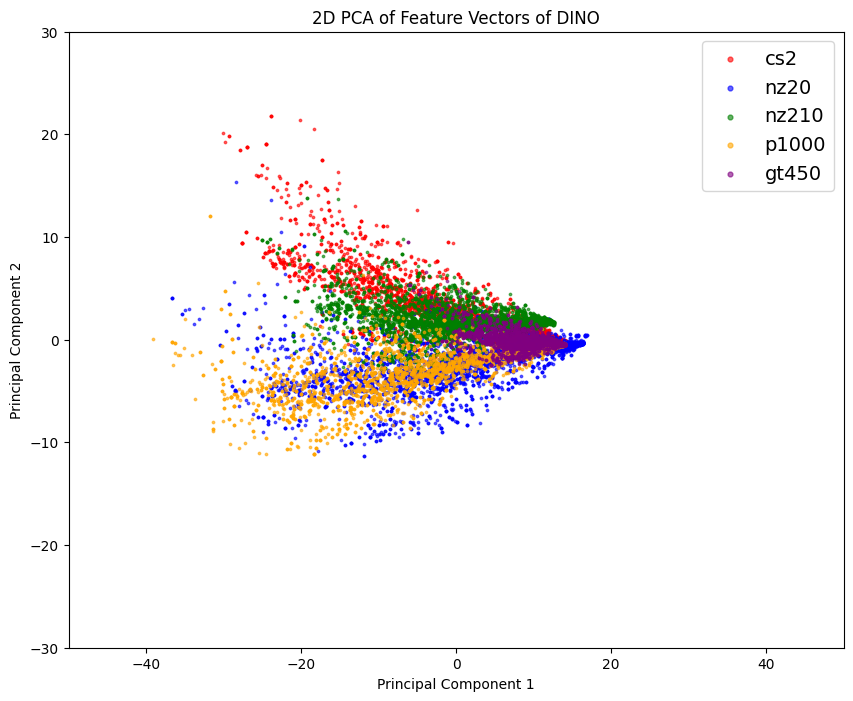

In [8]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import os

# Combine all feature vectors into one tensor and create labels
all_features = []
labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_map = {}

for i, scanner in enumerate(scan):
    for features, _ in testloaders[scanner]:
        all_features.append(features)
        labels.extend([scanner] * features.shape[0])
    color_map[scanner] = colors[i]

all_features = torch.cat(all_features, dim=0)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_2d = pca.fit_transform(all_features.numpy())

# Plot the 2D PCA
plt.figure(figsize=(10, 8))
for scanner in scan:
    indices = [i for i, label in enumerate(labels) if label == scanner]
    plt.scatter(reduced_2d[indices, 0], reduced_2d[indices, 1], label=scanner, color=color_map[scanner], alpha=0.6, s=3)

plt.title(f"2D PCA of Feature Vectors of DINO")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(fontsize=14, markerscale=2, loc='best')  # Example: fontsize 14, marker size 2x, best location

plt.xlim(xlim1, xlim2)
plt.ylim(ylim1, ylim2)

plt.savefig(os.path.join(pca_savepath, f"PCA_features_DINO.png"))
plt.show()

In [ ]:
from scanner_domain_shift.classifier_training.model_train_test_latent import inst_model, parseName, get_all_pth_file_paths
import torch

# models_folderpath = "/home/khinke/sc_domain_shift/models_latent_dino"
# model_paths = get_all_pth_file_paths(models_folderpath)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scannerident = "gt450"
modelpath = f"sc_domain_shift/models_latent_dinov2/{scannerident}_TwoLayerNN_epoch_12_lr_0.0001_512.pth"


input_size = 768

reduced_representations = {}
#parse model name
scannername, lr, epochs, modelname, hidden_size, hidden_size1, hidden_size2 = parseName(modelpath)
if modelname != "TwoLayerNN":
    print("Model not supported")
    

model, flatten_patches = inst_model(modelname, input_size, hidden_size, hidden_size1, hidden_size2, device)

# print(model)

# Load the model state
model.load_state_dict(torch.load(modelpath, weights_only=True))

reduced_representations = {}
for scannername in scan:
    temp_batches = []
    for patches, _ in testloaders[scannername]:
        patches = patches.to(device)
        patches = patches.view(patches.size(0), -1) if flatten_patches else patches
        with torch.no_grad():
            reduced_rep = model.get_reduced_representation(patches)
            temp_batches.append(reduced_rep.cpu())
    if len(temp_batches) > 0:
        reduced_representations[scannername] = torch.cat(temp_batches, dim=0)
        print(f"Final reduced representation shape for {scannername}: {reduced_representations[scannername].shape}")
    else:
        print(f"Warning: No data for {scannername}")

print(f"reduced_representations.keys(): {reduced_representations.keys()}")

    


    




scannername: gt450
modelname: TwoLayerNN
Parsed epochs: 12, learning rate: 0.0001, modelname: TwoLayerNN, hidden sizes: 512, None, None
Final reduced representation shape for cs2: torch.Size([2807, 512])
Final reduced representation shape for nz20: torch.Size([3367, 512])
Final reduced representation shape for nz210: torch.Size([3519, 512])
Final reduced representation shape for p1000: torch.Size([2592, 512])
Final reduced representation shape for gt450: torch.Size([2627, 512])
reduced_representations.keys(): dict_keys(['cs2', 'nz20', 'nz210', 'p1000', 'gt450'])


In [106]:
xlim1= -15
xlim2= 15
ylim1= -15
ylim2= 15

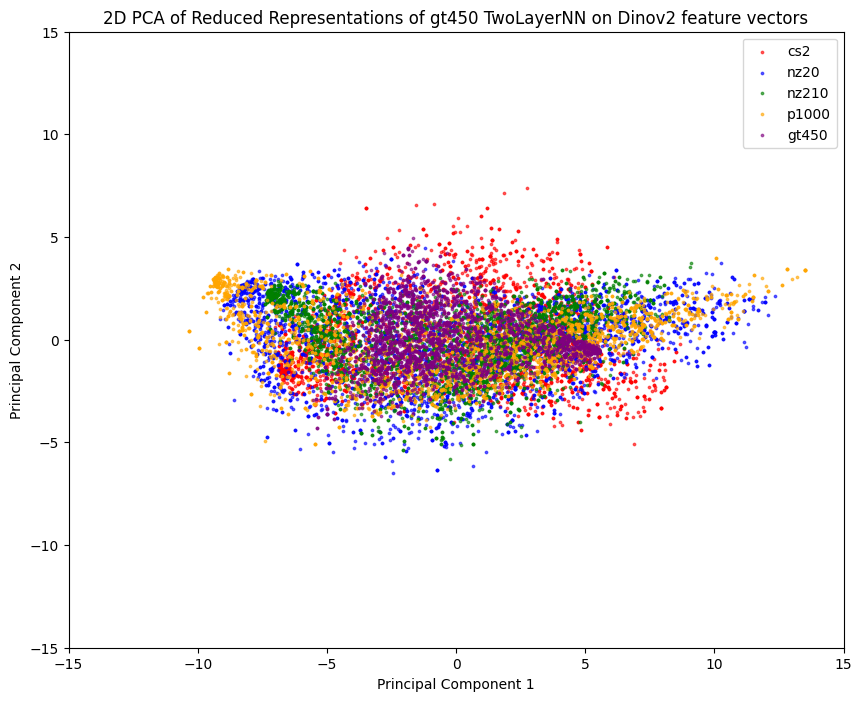

In [107]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure all reduced_representations are tensors (concatenate if needed)
for scanner in scan:
    if isinstance(reduced_representations[scanner], list):
        reduced_representations[scanner] = torch.cat(reduced_representations[scanner], dim=0)

# Perform PCA for each scanner's reduced representations
pca_results = {}
for scanner in scan:
    pca = PCA(n_components=2)
    pca_results[scanner] = pca.fit_transform(reduced_representations[scanner].cpu().numpy())

# Plot the 2D PCA results
plt.figure(figsize=(10, 8))
for scanner in scan:
    plt.scatter(
        pca_results[scanner][:, 0],
        pca_results[scanner][:, 1],
        label=scanner,
        color=color_map[scanner],
        alpha=0.6,
        s=3
    )

plt.title(f"2D PCA of Reduced Representations of {scannerident} TwoLayerNN on Dinov2 feature vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.xlim(xlim1, xlim2)
plt.ylim(ylim1, ylim2)

plt.savefig(os.path.join(pca_savepath, f"PCA_reduced_latent_{scannerident}_DINOv2.png"))
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure all reduced_representations are tensors (concatenate if needed)
for scanner in scan:
    if isinstance(reduced_representations[scanner], list):
        reduced_representations[scanner] = torch.cat(reduced_representations[scanner], dim=0)

# Perform PCA for each scanner's reduced representations
pca_results = {}
for scanner in scan:
    pca = PCA(n_components=2)
    pca_results[scanner] = pca.fit_transform(reduced_representations[scanner].cpu().numpy())

# Plot the 2D PCA results
plt.figure(figsize=(10, 8))
for scanner in scan:
    plt.scatter(
        pca_results[scanner][:, 0],
        pca_results[scanner][:, 1],
        label=scanner,
        color=color_map[scanner],
        alpha=0.6,
        s=3
    )

plt.title(f"2D PCA of Reduced Representations of {scannerident} TwoLayerNN on Dino feature vectors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.xlim(xlim1, xlim2)
plt.ylim(ylim1, ylim2)

plt.savefig(os.path.join(pca_savepath, f"PCA_reduced_latent_{scannerident}_DINO.png"))
plt.show()